In [4]:
import pandas as pd

file_path = 'data/Supplemental_Data_Raw_Genecounts.csv'

# Load the CSV file into a DataFrame.
df = pd.read_csv(file_path)
df = df.drop('Unnamed: 17', axis=1)
df = df.rename(columns={"Unnamed: 0": "mnra",})
df.set_index('mnra', inplace=True)
# Convert every non-index column to int
df = df.apply(pd.to_numeric, errors='coerce', downcast='integer')

# Pruning rows where all the values are 0.
# Assuming that you have columns 'x' and 'y', replace them with the actual names of your columns.
print(df.shape)
df = df[(df.loc[:, df.columns != 'index'] != 0).any(axis=1)]

(24411, 32)


In [5]:
columns_to_check = df.columns.difference(['Unnamed: 0'])

# Pruning rows where all the values in columns_to_check are 0.
df = df[(df[columns_to_check] != 0).any(axis=1)]


In [6]:
# Step 1: Calculate pairwise correlation
correlation_matrix = df.corr(method='pearson')



In [7]:
correlation_matrix

,A1.1.1,A1.1.2,A1.1.3,A1.1.4,A2.1.1,A2.1.2,A2.1.3,A2.1.4,A2.2.1,A2.2.2,...,B2.1.3,B2.1.4,B2.2.1,B2.2.2,B2.2.3,B2.2.4,B2.3.1,B2.3.2,B2.3.3,B2.3.4
A1.1.1,1.000000,0.995363,0.996998,0.990963,0.993878,0.996596,0.994670,0.978138,0.992643,0.996838,...,0.971333,0.961281,0.965662,0.967969,0.966357,0.963356,0.969600,0.971408,0.969775,0.607946
A1.1.2,0.995363,1.000000,0.998494,0.992591,0.994514,0.994615,0.992900,0.981149,0.992193,0.994516,...,0.978503,0.969663,0.973926,0.976932,0.975669,0.971472,0.975133,0.977023,0.976674,0.630597
A1.1.3,0.996998,0.998494,1.000000,0.991969,0.994569,0.995295,0.995489,0.981216,0.993100,0.996460,...,0.972590,0.963777,0.967251,0.969892,0.968921,0.965172,0.968436,0.970258,0.969863,0.625493
A1.1.4,0.990963,0.992591,0.991969,1.000000,0.991990,0.997004,0.995082,0.994503,0.995876,0.992076,...,0.977765,0.973623,0.977355,0.978458,0.980005,0.972759,0.973521,0.972896,0.975132,0.688317
A2.1.1,0.993878,0.994514,0.994569,0.991990,1.000000,0.996238,0.994407,0.982265,0.996251,0.997296,...,0.978667,0.969789,0.973675,0.977251,0.975231,0.971581,0.974034,0.977031,0.976599,0.625026
A2.1.2,0.996596,0.994615,0.995295,0.997004,0.996238,1.000000,0.997166,0.990046,0.998116,0.996802,...,0.975146,0.967794,0.973003,0.975084,0.974298,0.967989,0.971431,0.972327,0.972302,0.656838
A2.1.3,0.994670,0.992900,0.995489,0.995082,0.994407,0.997166,1.000000,0.989734,0.997121,0.997059,...,0.968909,0.961646,0.964045,0.965774,0.967196,0.961235,0.962291,0.962907,0.964946,0.653223
A2.1.4,0.978138,0.981149,0.981216,0.994503,0.982265,0.990046,0.989734,1.000000,0.992224,0.981526,...,0.964745,0.963553,0.968607,0.968771,0.972021,0.959599,0.956049,0.953833,0.958087,0.747684
A2.2.1,0.992643,0.992193,0.993100,0.995876,0.996251,0.998116,0.997121,0.992224,1.000000,0.995885,...,0.972169,0.964954,0.971267,0.973828,0.973384,0.964877,0.965914,0.966857,0.968144,0.674222
A2.2.2,0.996838,0.994516,0.996460,0.992076,0.997296,0.996802,0.997059,0.981526,0.995885,1.000000,...,0.973154,0.963556,0.966632,0.969998,0.968701,0.965233,0.968372,0.971326,0.971081,0.617166


In [8]:
filtered_corr_matrix = correlation_matrix.drop(index='B2.3.4', columns='B2.3.4')

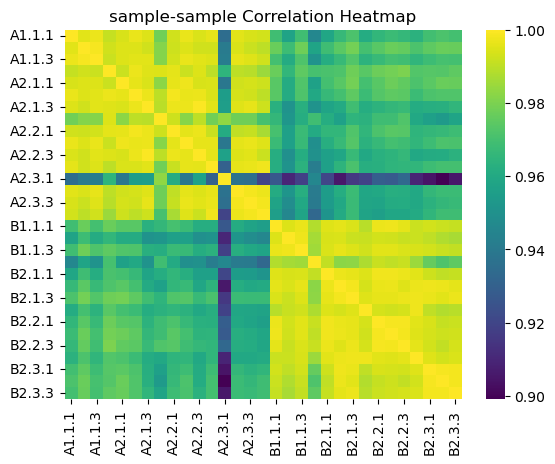

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(filtered_corr_matrix, annot=False, cmap='viridis')
plt.title('sample-sample Correlation Heatmap')
plt.show()

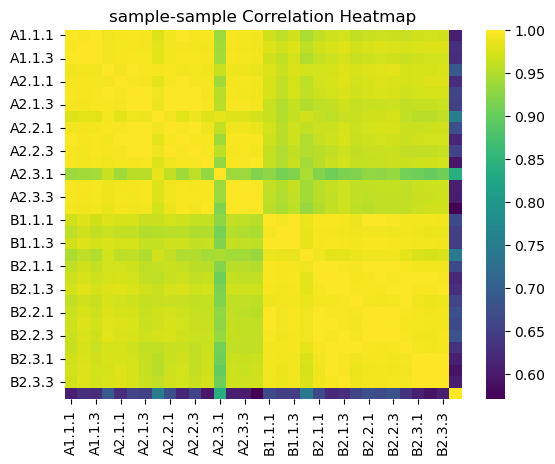

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(correlation_matrix, annot=False, cmap='viridis')
plt.title('sample-sample Correlation Heatmap')
plt.show()

In [11]:
# Calculate gene-gene correlation matrix in a single line
gene_correlation_matrix = df.T.corr(method='pearson')

In [12]:
gene_correlation_matrix

mnra,Xkr4,Rp1,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Oprk1,Npbwr1,...,Frmpd4,Msl3,Arhgap6,Hccs,Mid1,G530011O06Rik,Asmt,Eif2s3y,Ddx3y,Erdr1
mnra,,,,,,,,,,,,,,,,,,,,,
Xkr4,1.000000,0.326308,0.344113,0.634157,0.471540,0.721833,0.653017,0.648655,0.013945,-0.077947,...,0.658883,0.576103,0.478243,0.550392,0.285838,0.385085,-0.316994,-0.248249,0.039700,0.134118
Rp1,0.326308,1.000000,0.320489,0.258389,0.129845,0.300168,0.329519,0.209460,-0.197539,-0.125889,...,0.224856,0.146272,0.390012,0.140072,0.149732,0.219690,-0.125943,-0.097126,0.094288,0.098982
Sox17,0.344113,0.320489,1.000000,0.482072,0.514286,0.454976,0.132975,0.451260,0.183113,0.261162,...,0.511881,0.466927,0.030763,0.528994,0.103484,0.176501,-0.324215,-0.349558,0.288921,0.139312
Mrpl15,0.634157,0.258389,0.482072,1.000000,0.824988,0.888521,0.558821,0.898726,0.199984,0.292389,...,0.756165,0.852869,0.062944,0.882306,0.361886,0.423471,-0.172210,-0.206924,0.060709,0.436161
Lypla1,0.471540,0.129845,0.514286,0.824988,1.000000,0.795844,0.239906,0.888721,0.482496,0.628659,...,0.908206,0.913294,-0.320329,0.914165,0.208936,0.323541,-0.061258,-0.283183,0.249848,0.343342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G530011O06Rik,0.385085,0.219690,0.176501,0.423471,0.323541,0.540203,0.339730,0.421884,0.048469,0.113483,...,0.343359,0.357888,0.034227,0.450276,0.649963,1.000000,-0.122437,-0.103234,-0.141505,0.375261
Asmt,-0.316994,-0.125943,-0.324215,-0.172210,-0.061258,-0.097455,-0.042011,-0.093908,-0.059090,0.076233,...,-0.099995,-0.129622,0.003609,-0.126260,-0.075968,-0.122437,1.000000,0.239182,-0.137318,0.041629
Eif2s3y,-0.248249,-0.097126,-0.349558,-0.206924,-0.283183,-0.200429,-0.079982,-0.206284,-0.062373,-0.065236,...,-0.230384,-0.294665,0.028662,-0.224972,-0.244332,-0.103234,0.239182,1.000000,-0.041204,-0.279565


In [13]:
import numpy as np
import networkx as nx

# Select first 100 genes for testing
subset_corr_matrix = gene_correlation_matrix.iloc[:400, :400]
threshold = 0.90  # bootstrapping ?
filtered_subset_corr_matrix = subset_corr_matrix[(abs(subset_corr_matrix) >= threshold) & (subset_corr_matrix != 1.0)]

G_subset = nx.Graph()

for gene1 in filtered_subset_corr_matrix.index:
    for gene2 in filtered_subset_corr_matrix.columns:
        correlation = filtered_subset_corr_matrix.loc[gene1, gene2]
        if not np.isnan(correlation):
            G_subset.add_edge(gene1, gene2, weight=correlation)


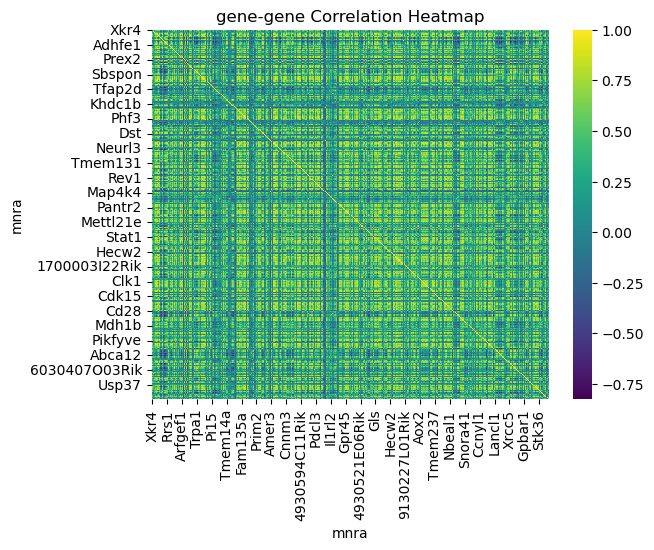

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(subset_corr_matrix, annot=False, cmap='viridis')
plt.title('gene-gene Correlation Heatmap')
plt.show()

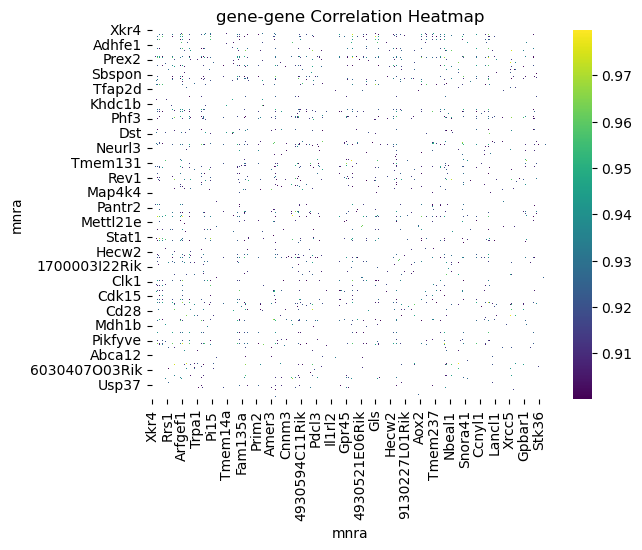

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(filtered_subset_corr_matrix, annot=False, cmap='viridis')
plt.title('gene-gene Correlation Heatmap')
plt.show()

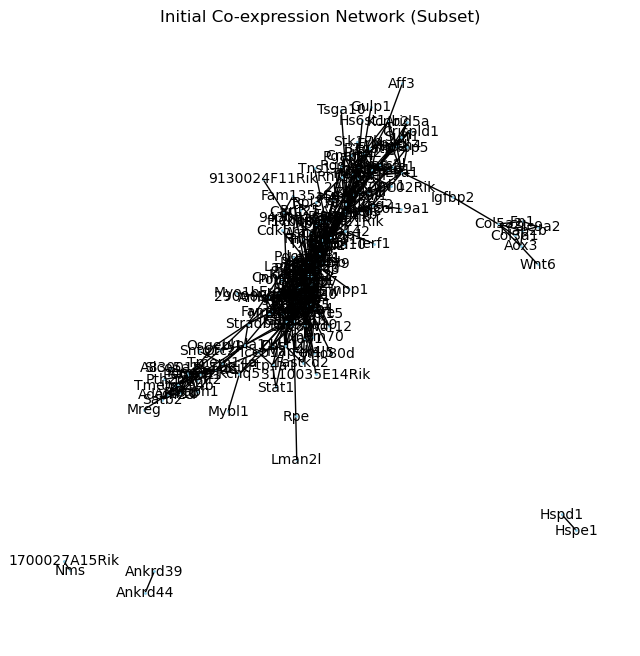

In [16]:

pos_subset = nx.spring_layout(G_subset)
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(G_subset, pos_subset, ax=ax, with_labels=True, node_color="skyblue", node_size=1, font_size=10)
plt.title("Initial Co-expression Network (Subset)")
plt.show()

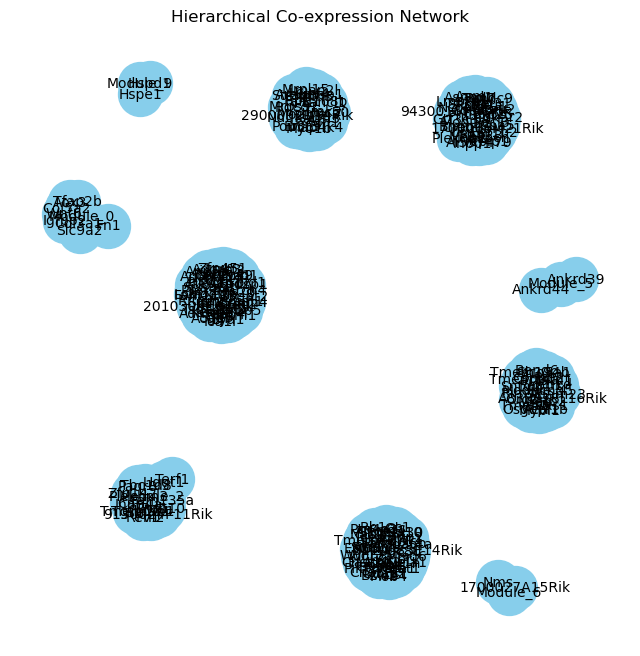

In [17]:
import community  # Python Louvain method library

# First compute the best partition
partition = community.best_partition(G_subset)

# Create a new graph to represent the hierarchical structure
G_hierarchy = nx.Graph()

for node, mod_class in partition.items():
    G_hierarchy.add_edge(node, f"Module_{mod_class}")

# Generate layout and draw the hierarchical network
pos_hierarchy = nx.spring_layout(G_hierarchy)
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(G_hierarchy, pos_hierarchy, with_labels=True, node_color="skyblue", node_size=1000, font_size=10)
plt.title("Hierarchical Co-expression Network")
plt.show()


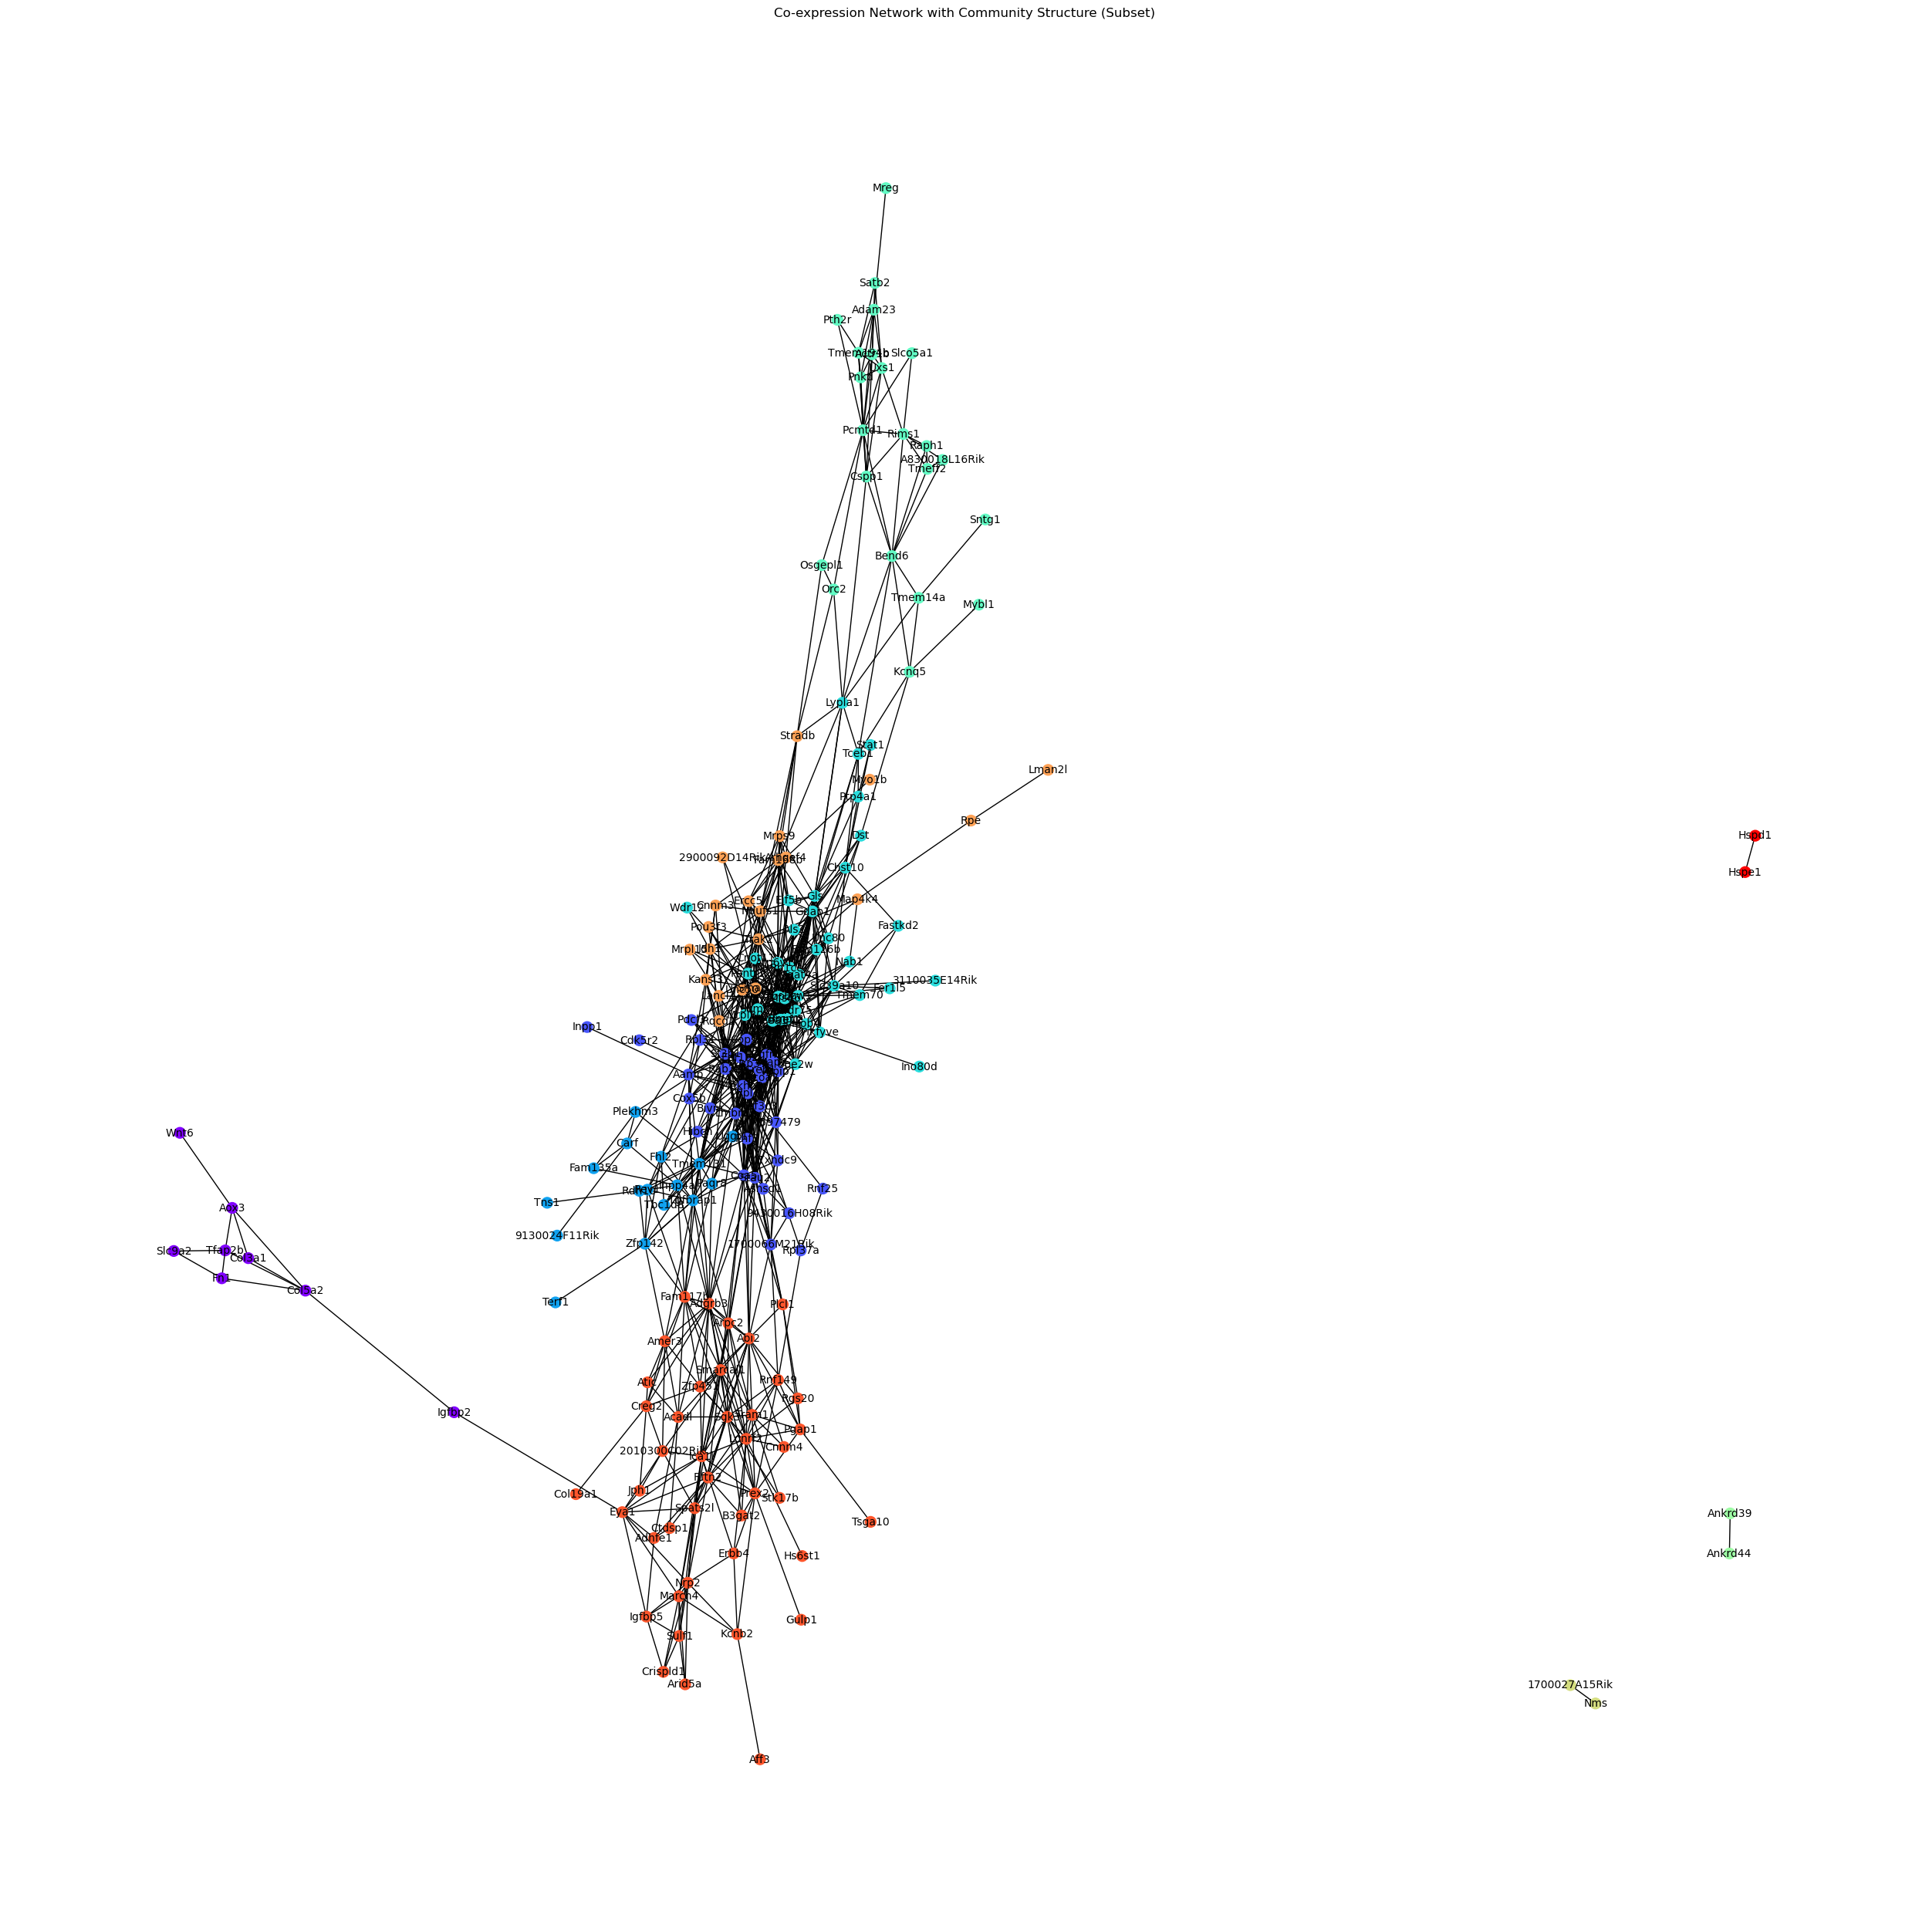

In [20]:
# Initialize a list to hold the colors for each node
colors = [partition[node] for node in G_subset.nodes()]

# Create the layout and plot the network
pos_subset = nx.spring_layout(G_subset)
fig, ax = plt.subplots(figsize=(32, 32))
nx.draw(G_subset, pos_subset, ax=ax, with_labels=True, node_color=colors, cmap=plt.cm.rainbow, node_size=100, font_size=10)
plt.title("Co-expression Network with Community Structure (Subset)")
plt.show()


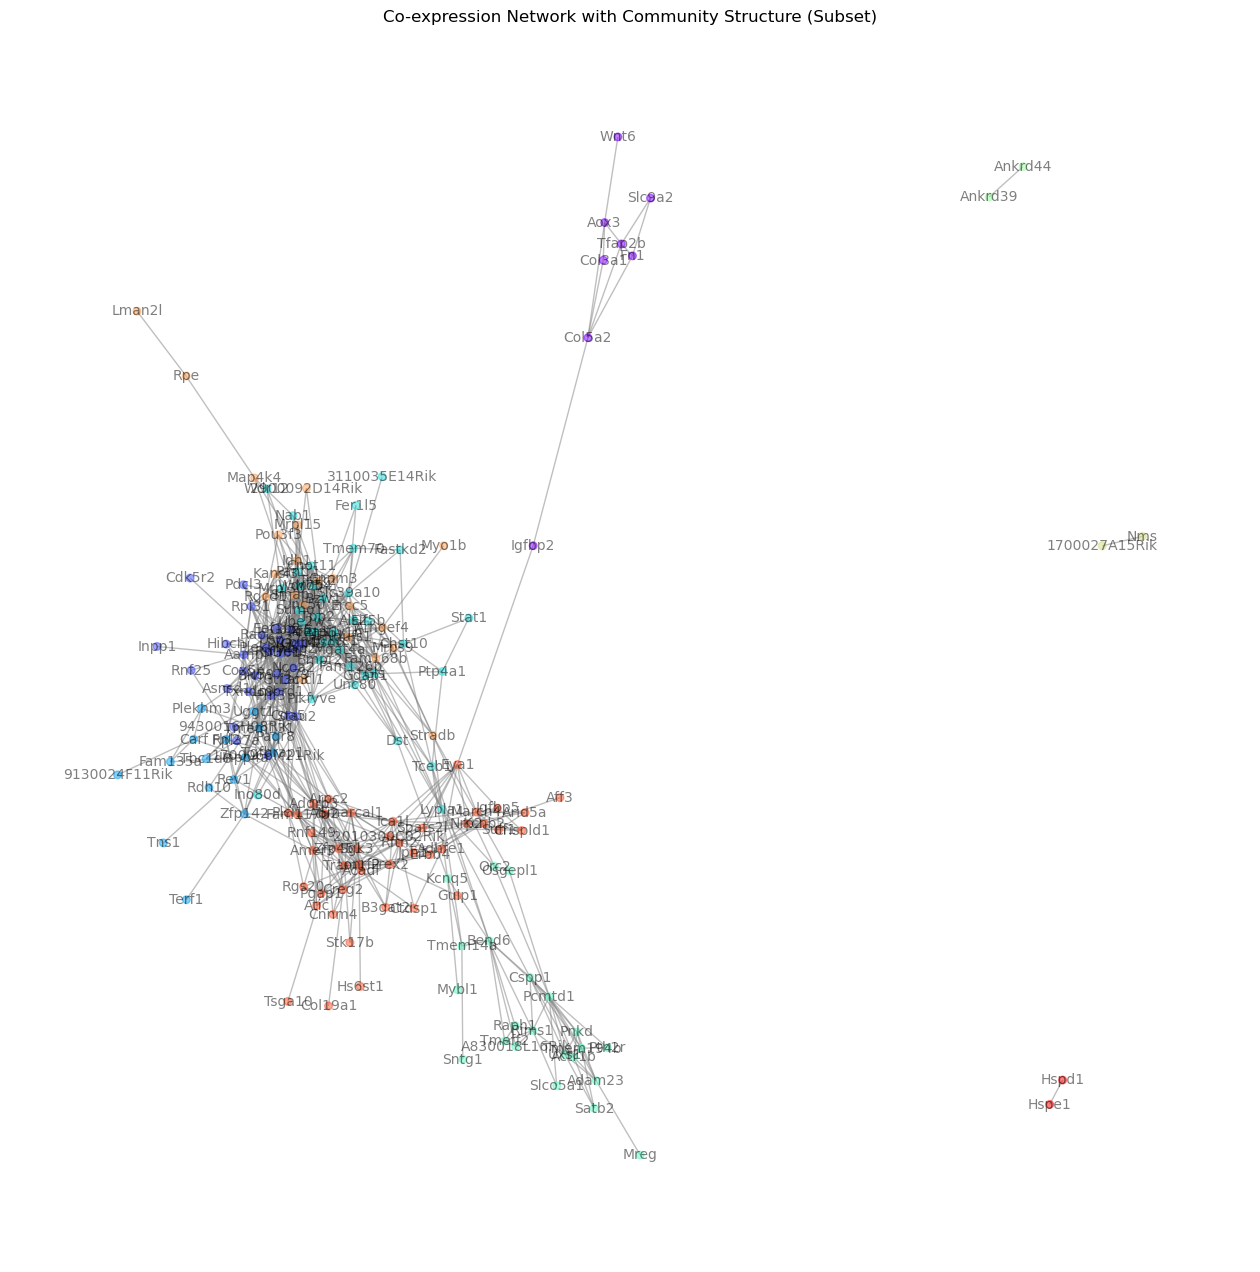

In [23]:
# Initialize a list to hold the colors for each node
colors = [partition[node] for node in G_subset.nodes()]

# Create the layout and plot the network
pos_subset = nx.spring_layout(G_subset)
fig, ax = plt.subplots(figsize=(16, 16))
nx.draw(G_subset, pos_subset, ax=ax, with_labels=True, node_color=colors, cmap=plt.cm.rainbow, node_size=30, font_size=10, edge_color="grey", alpha=0.5)
plt.title("Co-expression Network with Community Structure (Subset)")
plt.show()
